## The Convolutional Neural Network

We will use a convolutional neural network to detect the emotions. 
We will train our model using the FER2013 dataset. Then, using the trained model, we will detect the emotions in the faces detected in the video stream captured by the camera or the video file.


In [38]:
import tensorflow  as  tf
from  tensorflow  import  keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import train_test_split
import sklearn

import numpy as  np
import matplotlib.pyplot  as  plt
import os
import cv2
import random
import cv2 as cv
import pandas  as  pd
import tqdm as tqdm


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#print the number of GPU

print ( "Num GPUs Available: " ,  len ( tf.config.experimental.list_physical_devices ( 'GPU' )))

Num GPUs Available:  1


2022-12-14 17:02:29.036272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:02:29.036474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:02:29.036569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:02:29.036693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:02:29.036920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# Load the dataset

Load and differentiate between training and testing data (they are spit in two folders, one for training and one for testing).

In [39]:
datasetToUse = "GoogleFer" # "CK+48" or "FER2013" or "GoogleFer" or "datasetGigante"

### FER2013 dataset

In [ ]:
#load the data
if datasetToUse == "FER2013":
        
        path = "./dataset/FER2013/"
        test_path = path + "test/"
        train_path = path + "train/"


        train_x = []
        train_y = []
        val_x = []
        val_y = []

        #load the train data

        classes = { "angry" : 0,  "disgust" : 1,  "fear" : 2,  "happy" : 3,  "sad" : 4,  "surprise" : 5,  "neutral" : 6}
        classesDiz2 = { 0 : "angry" ,  1 : "disgust" ,  2 : "fear" ,  3 : "happy" ,  4 : "sad" ,  5 : "surprise" ,  6 : "neutral" }

        data_generator = ImageDataGenerator(rescale=1./255)




        batch_size = 32
        # Preprocess all test images
        train_generator = data_generator.flow_from_directory(
                train_path,
                target_size=(48, 48),
                batch_size=64,
                color_mode="grayscale",
                class_mode='categorical')

        # Preprocess all train images
        validation_generator = data_generator.flow_from_directory(
                test_path,
                target_size=(48, 48),
                batch_size=64,
                color_mode="grayscale",
                class_mode='categorical')

                




                



train_x shape:  (32645, 48, 48)
train_y shape:  (32645, 8)
val_x shape:  (8166, 48, 48)
val_y shape:  (8166, 8)


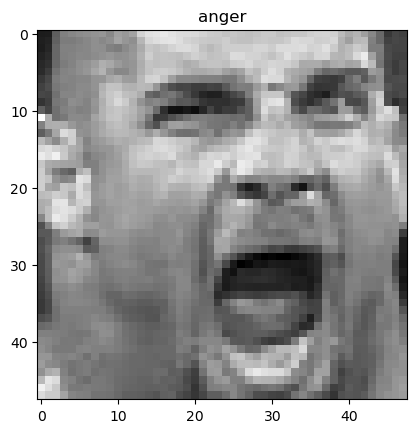

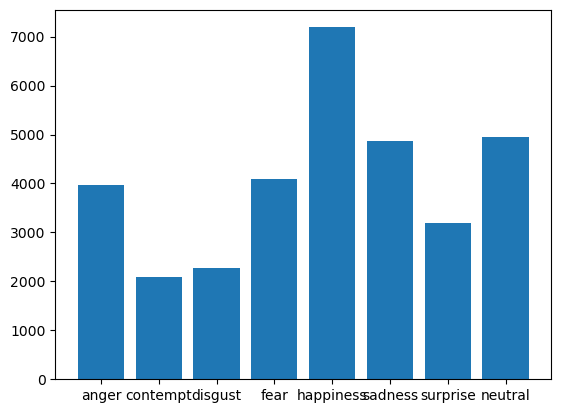

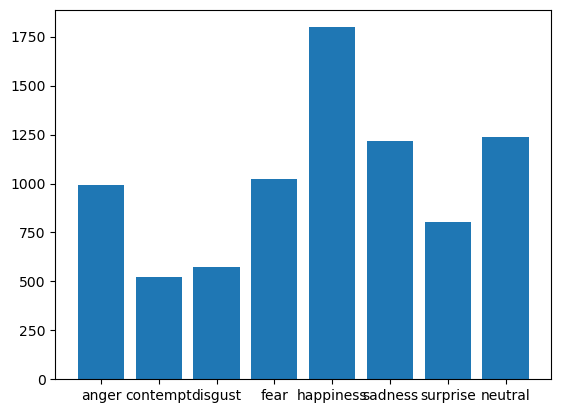

In [40]:
if datasetToUse == "GoogleFer":


        path = "./dataset/GoogleFer/"
        test_path = path + "val/"
        train_path = path + "train/"

        classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happiness" : 4,  "sadness" : 5,  "surprise" : 6,  "neutral" : 7}

        classesReversed = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happiness" ,  5 : "sadness" ,  6 : "surprise" ,  7 : "neutral" }
        num_classes = 8

        batch_size = 32
        


        train_x = []
        train_y = []
        val_x = []
        val_y = []

        #load the train data

        

        contClassesTrain = { "anger" : 0,  "contempt" : 0,  "disgust" : 0,  "fear" : 0,  "happiness" : 0,  "sadness" : 0,  "surprise" : 0,  "neutral" : 0}
        contClassesTest = { "anger" : 0,  "contempt" : 0,  "disgust" : 0,  "fear" : 0,  "happiness" : 0,  "sadness" : 0,  "surprise" : 0,  "neutral" : 0}



        for i in classes:
                #convert i to upper case
                #i = i.upper()    
                path = os.path.join(train_path, i.upper())
                 
                for img in os.listdir(path):
                        img_array = cv2.imread (os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        #new_array = cv2.resize(img_array, (48, 48))
                        train_x.append(img_array)
                        train_y.append(classes[i])
                        contClassesTrain[i] = contClassesTrain[i] + 1

        #load the test data
        for i in classes:
                #i = i.upper()  
                path = os.path.join(test_path, i.upper())
               
                 
                for img in os.listdir(path):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        #new_array = cv2.resize(img_array, (48, 48))
                        val_x.append(img_array)
                        val_y.append(classes[i])
                        contClassesTest[i] = contClassesTest[i] + 1

        #convert the val_x and train_x to numpy array
        train_x = np.array(train_x)
        train_y = keras.utils.to_categorical(train_y, 8)
        val_x = np.array(val_x)
        val_y = keras.utils.to_categorical(val_y, 8)

        print ( "train_x shape: " , train_x.shape)
        print ( "train_y shape: " , train_y.shape)
        print ( "val_x shape: " , val_x.shape)
        print ( "val_y shape: " , val_y.shape)


        data_generator = ImageDataGenerator(
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,        
                                        zoom_range=0.3
                                        )
        

        #reshape the data
        train_x = train_x.reshape(train_x.shape[0], 48, 48, 1)
        val_x = val_x.reshape(val_x.shape[0], 48, 48, 1)

        train_generator = data_generator.flow(train_x, train_y, batch_size=batch_size)
        validation_generator = data_generator.flow(val_x, val_y, batch_size=batch_size)

        


        randomIndex = random.randint(0, len(train_x))
        #plot the first image
        plt.imshow(train_x[randomIndex].reshape(48, 48), cmap='gray')
        #label it
        plt.title(classesReversed[np.argmax(train_y[randomIndex])])
        plt.show()



        #plot the contClassesTrain
        plt.bar(range(len(contClassesTrain)), list(contClassesTrain.values()), align='center')
        plt.xticks(range(len(contClassesTrain)), list(contClassesTrain.keys()))
        plt.show()

        #plot the contClassesTest
        plt.bar(range(len(contClassesTest)), list(contClassesTest.values()), align='center')
        plt.xticks(range(len(contClassesTest)), list(contClassesTest.keys()))
        plt.show()
        


        





    

### CK+ dataset

CK+ dataset

In [ ]:

#load the data
if datasetToUse == "CK+48":
    dataset_path = "./dataset/CK+48/"

    label_images = {
        "anger" : [],
        "contempt" : [],
        "disgust" : [],
        "fear" : [],
        "happy" : [],
        "sadness" : [],
        "surprise" : []
    }

    for folder in os.listdir(dataset_path):
        for file in os.listdir(dataset_path + folder):
            image = cv.imread(dataset_path + folder + "/" + file, 0)

            label_images[folder].append(np.array(image))

    #for each label, take 80% of the images for training and 20% for testing
    train_x = []
    train_y = []
    val_x = []
    val_y = []

    classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happy" : 4,  "sadness" : 5,  "surprise" : 6}
    classesDiz2 = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happy" ,  5 : "sadness" ,  6 : "surprise" }

    for label in label_images:
        cont = 0
        for image in label_images[label]:
            if cont < len(label_images[label]) * 0.8:
                train_x.append(image)
                train_y.append(classes[label])
            else:
                val_x.append(image)
                val_y.append(classes[label])
            cont += 1
            

    train_x = np.array(train_x)
    train_y = np.array(train_y)

    val_x = np.array(val_x)
    val_y = np.array(val_y)

    #print the shape of the data


            

    data_generator = ImageDataGenerator(rescale=1./255)

    #reshape the data
    train_x = train_x.reshape(train_x.shape[0], 48, 48, 1)
    val_x = val_x.reshape(val_x.shape[0], 48, 48, 1)


    print ( "Train data shape: " , train_x.shape)
    print ( "Train labels shape: " , train_y.shape)
    print ( "Test data shape: " , val_x.shape)
    print ( "Test labels shape: " , val_y.shape)


    #convert the labels to categorical
    train_y = keras.utils.to_categorical(train_y, 7)
    val_y = keras.utils.to_categorical(val_y, 7)

 



    # Preprocess all test images
    train_generator = data_generator.flow(
            train_x,
            train_y,    #as the batch size, select the entire dataset
            
    )
    

    # Preprocess all train images
    validation_generator = data_generator.flow(
            val_x,
            val_y,
            
    )


    num_classes = 7
    classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happy" : 4,  "sadness" : 5,  "surprise" : 6}



    

    



    



### Dataset Gigante

In [ ]:
if datasetToUse == "datasetGigante":

    path = "./dataset/datasetGigante/"

    #load the CVS that contains the labels
    labels = pd.read_csv(path + "labels.csv")

   #plot the first rows of the labels
    print (labels.head())

    
    #get the number of unique labels
    print ( "Number of unique labels: " , len(labels.label.unique()))

    classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happy" : 4,  "sad" : 5,  "surprise" : 6,  "neutral" : 7}

    classesReversed = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happy" ,  5 : "sad" ,  6 : "surprise" ,  7 : "neutral" }

    #create a dictionary that contains as key the label and as value an empty list
    label_images = {
        "anger" : [],
        "contempt" : [],
        "disgust" : [],
        "fear" : [],
        "happy" : [],
        "sad" : [],
        "surprise" : [],
        "neutral" : []
    }

    for folder in os.listdir(path):

        #check whether the folder is actually a folder
        if not os.path.isdir(path + folder):
            continue
        #use tqdm to show the progress
        print ( "Loading images from " , folder)
        for file in tqdm.tqdm(os.listdir(path + folder)):
            #the image is in color
            imagePath = path + folder + "/" + file
            imageName = folder + "/" + file
            
            #in the csv, there are two columns: the image name called pth and the label
            #get the label of the image
            label = labels.loc[labels['pth'] == imageName, 'label'].iloc[0]
            
            #load the image is in color
            image = cv.imread(imagePath, cv.IMREAD_GRAYSCALE)
            #resize the image
            image = cv.resize(image, (48, 48))
            
            #add the image to the dictionary
            label_images[label].append(np.array(image))

    #plot 5 images per label
    for label in label_images:
        for i in range(5):
            plt.imshow(label_images[label][i], cmap = "gray")
            plt.title(label)
            plt.show()

    

    #for each label, take 80% of the images for training and 20% for testing
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    for label in label_images:
        cont = 0
        for image in label_images[label]:
            if cont < len(label_images[label]) * 0.8:
                train_x.append(image)
                train_y.append(classes[label])
            else:
                val_x.append(image)
                val_y.append(classes[label])
            cont += 1
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    val_x = np.array(val_x)
    val_y = np.array(val_y)
    #reshape the data
    train_x = train_x.reshape(train_x.shape[0], 48, 48, 1)
    val_x = val_x.reshape(val_x.shape[0], 48, 48, 1)
    #print the shape of the data
    print ( "Train data shape: " , train_x.shape)
    print ( "Train labels shape: " , train_y.shape)
    print ( "Test data shape: " , val_x.shape)
    print ( "Test labels shape: " , val_y.shape)
    #convert the labels to categorical
    train_y = keras.utils.to_categorical(train_y, 8)
    val_y = keras.utils.to_categorical(val_y, 8)

    data_generator = ImageDataGenerator(rescale=1./255)
    # Preprocess all test images
    train_generator = data_generator.flow(
            train_x,
            train_y,    #as the batch size, select the entire dataset
    )
    # Preprocess all train images
    validation_generator = data_generator.flow(
            val_x,
            val_y,
    )
    num_classes = 8




            

    



    

    


### AffectNet dataset
https://www.kaggle.com/datasets/tom99763/affectnethq

## Train the model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Convolution2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential



In [ ]:
input_shape=(48, 48, 1)
weight_decay = 1e-4

modelType = "EmotionNet"




def EmotionNet():

    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))

    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('softmax'))


    

    return model
    


def modelFromYoutube():

    model = keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


def ResNet():




    pass
                
# create the model

if modelType == "EmotionNet":
    model = EmotionNet()
elif modelType == "modelFromYoutube":
    model = modelFromYoutube()


model.summary()




In [ ]:

#train the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=6,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)


callbacks = [
    early_stopping,
    lr_scheduler,
]



train_x = train_x / 255.
val_x = val_x / 255.


In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=callbacks, verbose=1)

In [ ]:
print(model.evaluate(val_x, val_y))

print(model.evaluate(validation_generator))

#plot the accuracy and loss
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [ ]:
#save the model as model name
model.save("modelEmotionNet+GoogleFer66.h5")


# Setup the application

In [ ]:
#import the module to read from webcam 
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
#import accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix




The cell below captures a video stream of the camera and displays it in the notebook. The video stream is captured using the OpenCV library. 
If we want to capture from a video file, we can use the following code:

cv.VideoCapture('project_video.mp4')

On the other hand, if we want to use the camera, we can use the following code:

cv.VideoCapture(0)


In [ ]:
videoPath = "METTERE QUI IL PATH DEL VIDEO"

if videoPath == "METTERE QUI IL PATH DEL VIDEO" or videoPath == "":
    cap = cv.VideoCapture(0)
else:
    cap = cv.VideoCapture(videoPath)

#there are 8 emotions
num_classes = 8

classes = classesReversed
print(classes)

    


Below, we will choose if we want to dected the frontal faces, the profile or both. We will use the frontal face cascade classifier by default.

In [ ]:
haarDetectionMode = "profile"

In [ ]:
haarDetectionMode = "profileAndFrontal"

In [ ]:
haarDetectionMode = "frontal"

In [ ]:
saveCroppedFaces = False
predictEmotions = True

The function detect faces uses haar cascade to detect faces in the frame. 
There are two versions of haar cascades, one for profile faces and one for frontal faces.



In [ ]:
def detectFaces(frame):

    detectedFaces = []


    #use haar cascade to detect faces
    if haarDetectionMode == "frontal" or haarDetectionMode == "profileAndFrontal":
        faceCascadeFrontal = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        facesFrontal = faceCascadeFrontal.detectMultiScale(frame, 1.1, 4)

        detectedFaces.extend(facesFrontal)

    elif haarDetectionMode == "profile" or haarDetectionMode == "profileAndFrontal":
        faceCascadeProfile = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_profileface.xml')
        facesProfile = faceCascadeProfile.detectMultiScale(frame, 1.1, 4)

        detectedFaces.extend(facesProfile)




    

    return detectedFaces

In [ ]:
def drawRectangleFace(frame, facesCoordinates):
    #draw the rectangle around the face
    frameWithRectangle = frame.copy()
    for (x, y, w, h) in facesCoordinates:
        cv.rectangle(frameWithRectangle, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    return frameWithRectangle
        
        
    
        

In [ ]:
def plotImage(image):
    plt.imshow(image)
    plt.show()

In [ ]:
def predictEmotion(face):
    #resize the image
    face = cv.resize(face, (48, 48))

    #convert the image to float
    face = face.astype('float32')
    #normalize the image
    face /= 255
    #reshape the image
    face = face.reshape(1, 48, 48, 1)
    #predict the emotion
    emotion = model.predict(face)
    return emotion

In [ ]:
if predictEmotions:
    #load the model
    model = keras.models.load_model('modelEmotionNet+GoogleFer66.h5')
    

In [ ]:
def writeEmotionOnImage(frame, facesCoordinates, emotions):
    frameWithEmotion = frame.copy()
    for (x, y, w, h), emotion in zip(facesCoordinates, emotions):
        #get the emotion with the highest probability and write the confidence
        emotion1 = classes[np.argmax(emotion)]
        confidence = np.max(emotion)
        cv.putText(frameWithEmotion, emotion1 + " " + str(confidence), (x, y), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv.LINE_AA)



        

    return frameWithEmotion

In [ ]:

def showVideo():
    ret,frame = cap.read()

    if not ret:
        print("Unable to capture video")
        exit()
        
    
    #flip the image
    frame = cv.flip(frame,1)
    grayFrame = frame
    #convert the image to grayscale
    if frame is not None:
        grayFrame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        

    

    #detect the face
    facesCoordinates = detectFaces(grayFrame)

    #draw the rectangle around the face
    frameToShow = drawRectangleFace(frame, facesCoordinates)

    if predictEmotions:

        emotions = []
        for (x, y, w, h) in facesCoordinates:
            #crop the face
            face = grayFrame[y:y+h, x:x+w]
            face = cv.resize(face, (48, 48))
            #convert to numpy array
            face = np.array(face)
            face.reshape(48, 48, 1)

            #save the face
            if saveCroppedFaces:
                cv.imwrite("./savedFaces/face.jpg", face)
            


            #predict the emotion
            emotion = predictEmotion(face)
            emotions.append(emotion)
            

        frameToShow = writeEmotionOnImage(frameToShow, facesCoordinates, emotions)


    #display the image
    cv.imshow('frame',frameToShow)
    ret = True
    if cv.waitKey(1) & 0xFF == ord('q'):
        ret = False
        
    return ret, frame, facesCoordinates

In [ ]:
ret = True
while ret:
    
    

    #show the video with the face detected
    ret, frame, facesCoordinates = showVideo()


                
            
    
#release the camera
cap.release()
#close all windows
cv.destroyAllWindows()

# Feature Extraction using VGG16

In [ ]:
#import the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.neighbors import KNeighborsClassifier

#extract the features from the images
def extractFeatures(images):
    features = featuatureExtractionModel.predict(images)
    #reshape the features
    features = features.reshape(features.shape[0], -1)
    return features



featuatureExtractionModel = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

#freeze the layers
for layer in featuatureExtractionModel.layers:
    layer.trainable = False


train_x = []
train_y = []

val_x = []
val_y = []


for folder in os.listdir("./dataset/GoogleFer/train/"):
    for file in os.listdir("./dataset/GoogleFer/train/" + folder):
        image = cv.imread("./dataset/GoogleFer/train/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        train_x.append(image)
        train_y.append(folder)

for folder in os.listdir("./dataset/GoogleFer/val/"):
    for file in os.listdir("./dataset/GoogleFer/val/" + folder):
        image = cv.imread("./dataset/GoogleFer/val/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        val_x.append(image)
        val_y.append(folder)





train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = np.array(val_x)
val_y = np.array(val_y)



print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)



train_x = extractFeatures(train_x)
val_x = extractFeatures(val_x)
print("Finished extracting features")






In [ ]:
#train a softmax classifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_x, train_y)

#evaluate the model
print(classifier.score(val_x, val_y))


# Feature extraction using my model

In [1]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Convolution2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential





import tensorflow  as  tf
from  tensorflow  import  keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import train_test_split
import sklearn

import numpy as  np
import matplotlib.pyplot  as  plt
import os
import cv2
import random
import cv2 as cv
import pandas  as  pd
import tqdm as tqdm


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#print the number of GPU

print ( "Num GPUs Available: " ,  len ( tf.config.experimental.list_physical_devices ( 'GPU' )))

#import the module to read from webcam 
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
#import accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import pickle

2022-12-14 21:09:03.198594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 21:09:03.470875: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-14 21:09:03.610788: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-14 21:09:04.422926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Num GPUs Available:  1


2022-12-14 21:09:06.551511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:09:06.552263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:09:06.552454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:09:06.552612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3614 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-12-14 21:09:06.555626: I tensorflow/stream_executor/cuda/cuda_

In [2]:
#load my model 
model = keras.models.load_model('modelEmotionNet+GoogleFer66.h5')

flag = True


#create a new model starting from model until flatten
newModel = keras.models.Model(inputs=model.input, outputs=model.get_layer('dropout_3').output)
# print("New model:")
# newModel.summary()



2022-12-14 17:44:01.350225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:44:01.350402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:44:01.350479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:44:01.350597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:44:01.350677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [92]:

train_x = []
train_y = []

val_x = []
val_y = []


for folder in os.listdir("./dataset/GoogleFer/train/"):
    for file in os.listdir("./dataset/GoogleFer/train/" + folder):
        image = cv.imread("./dataset/GoogleFer/train/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        #convert to grayscale
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        train_x.append(image)
        train_y.append(folder)

for folder in os.listdir("./dataset/GoogleFer/val/"):
    for file in os.listdir("./dataset/GoogleFer/val/" + folder):
        image = cv.imread("./dataset/GoogleFer/val/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        #convert to grayscale
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        val_x.append(image)
        val_y.append(folder)





train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = np.array(val_x)
val_y = np.array(val_y)

train_x = train_x / 255.0
val_x = val_x / 255.0



print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)




(32645, 48, 48)
(32645,)
(8166, 48, 48)
(8166,)


In [93]:
def extractFeatures(model, images):
    features = model.predict(images)
    #reshape the features
    features = features.reshape(features.shape[0], -1)
    return features
    

In [94]:
train_x = extractFeatures(newModel, train_x)

val_x = extractFeatures(newModel, val_x)
print("Finished extracting features")







256/256 [==============================] - 1s 5ms/step
Finished extracting features


In [95]:
#now save the extracted features
np.save("./extractedFeatures/train_x.npy", train_x)
np.save("./extractedFeatures/train_y.npy", train_y)
np.save("./extractedFeatures/val_x.npy", val_x)
np.save("./extractedFeatures/val_y.npy", val_y)

print("Saved extracted features")

#print the shape of the extracted features
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)



Saved extracted features
(32645, 4608)
(32645,)
(8166, 4608)
(8166,)


In [2]:
#load the saved features
train_x = np.load("./extractedFeatures/train_x.npy")
train_y = np.load("./extractedFeatures/train_y.npy")
val_x = np.load("./extractedFeatures/val_x.npy")
val_y = np.load("./extractedFeatures/val_y.npy")

print("Loaded extracted features")

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)




Loaded extracted features
(32645, 4608)
(32645,)
(8166, 4608)
(8166,)


In [3]:

#the shape is (32645, 4608). 
#The first dimension is the number of images
#The second dimension is the number of features extracted from the model

#take only the first 128 features
train_x = train_x[:, :]
val_x = val_x[:, :]


print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)







(32645, 4608)
(32645,)
(8166, 4608)
(8166,)


In [98]:
from sklearn.neighbors import KNeighborsClassifier
#train a knn classifier
for i in range(1, 10):
    print("KNN with k = " + str(i))
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(train_x, train_y)

    #save the model using pickle
    filename = './models/KNN' + str(i) + '.pickle'
    pickle.dump(classifier, open(filename, 'wb'))

    pred = classifier.predict(val_x)
    #print(pred)

    #evaluate the model
    print("The accuracy is: " + str(accuracy_score(val_y, pred)))

    #print the report of the model
    print(sklearn.metrics.classification_report(val_y, pred))

    #save the preds
    np.save("./risults/KNN" + str(i) + ".npy", pred)



    
    

    

    


KNN with k = 1
The accuracy is: 0.6729120744550575
              precision    recall  f1-score   support

       ANGER       0.57      0.50      0.53       991
    CONTEMPT       0.95      0.95      0.95       524
     DISGUST       0.91      0.89      0.90       571
        FEAR       0.49      0.48      0.49      1025
   HAPPINESS       0.85      0.82      0.84      1798
     NEUTRAL       0.57      0.57      0.57      1240
     SADNESS       0.49      0.57      0.53      1216
    SURPRISE       0.76      0.77      0.76       801

    accuracy                           0.67      8166
   macro avg       0.70      0.69      0.70      8166
weighted avg       0.68      0.67      0.67      8166

KNN with k = 2
The accuracy is: 0.6471956894440363
              precision    recall  f1-score   support

       ANGER       0.46      0.60      0.52       991
    CONTEMPT       0.90      0.96      0.93       524
     DISGUST       0.93      0.83      0.88       571
        FEAR       0.40      0

In [5]:
#use a naive bayes classifier from sklearn
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(train_x, train_y)

#evaluate the model
pred = classifier.predict(val_x)
print("The accuracy is: " + str(accuracy_score(val_y, pred)))

#save the model using pickle
filename = './models/NaiveBayes.pickle'
pickle.dump(classifier, open(filename, 'wb'))

#save the preds
np.save("./risults/NaiveBayes.npy", pred)




print(sklearn.metrics.classification_report(val_y, pred))


The accuracy is: 0.6699730590252265
              precision    recall  f1-score   support

       ANGER       0.58      0.52      0.55       991
    CONTEMPT       0.88      0.88      0.88       524
     DISGUST       0.91      0.70      0.79       571
        FEAR       0.50      0.28      0.36      1025
   HAPPINESS       0.91      0.84      0.87      1798
     NEUTRAL       0.57      0.69      0.62      1240
     SADNESS       0.47      0.65      0.55      1216
    SURPRISE       0.73      0.81      0.77       801

    accuracy                           0.67      8166
   macro avg       0.69      0.67      0.67      8166
weighted avg       0.68      0.67      0.67      8166



In [6]:
#use a svm classifier
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(train_x, train_y)

#save the model using pickle
filename = './models/SVMlinear.pickle'
pickle.dump(classifier, open(filename, 'wb'))

print("Model saved")

pred = classifier.predict(val_x)

#evaluate the model
print("The accuracy is: " + str(accuracy_score(val_y, pred)))

#save the preds
np.save("./risults/SVMlinear.npy", pred)

print(sklearn.metrics.classification_report(val_y, pred))






Model saved
The accuracy is: 0.6705853539064414
              precision    recall  f1-score   support

       ANGER       0.50      0.58      0.53       991
    CONTEMPT       0.95      0.95      0.95       524
     DISGUST       0.91      0.89      0.90       571
        FEAR       0.45      0.49      0.47      1025
   HAPPINESS       0.85      0.86      0.85      1798
     NEUTRAL       0.59      0.54      0.57      1240
     SADNESS       0.51      0.47      0.49      1216
    SURPRISE       0.81      0.77      0.79       801

    accuracy                           0.67      8166
   macro avg       0.70      0.69      0.69      8166
weighted avg       0.67      0.67      0.67      8166



In [4]:
#load the svm linear model
filename = './models/SVMlinear.pickle'
classifier = pickle.load(open(filename, "rb"))

print("Model loaded")

pred = classifier.predict(val_x)

print("Predicted")

#evaluate the model
print("The accuracy is: " + str(accuracy_score(val_y, pred)))

#save the preds
np.save("./risults/SVMlinear.npy", pred)

print(sklearn.metrics.classification_report(val_y, pred))



Model loaded
Predicted
The accuracy is: 0.6705853539064414
              precision    recall  f1-score   support

       ANGER       0.50      0.58      0.53       991
    CONTEMPT       0.95      0.95      0.95       524
     DISGUST       0.91      0.89      0.90       571
        FEAR       0.45      0.49      0.47      1025
   HAPPINESS       0.85      0.86      0.85      1798
     NEUTRAL       0.59      0.54      0.57      1240
     SADNESS       0.51      0.47      0.49      1216
    SURPRISE       0.81      0.77      0.79       801

    accuracy                           0.67      8166
   macro avg       0.70      0.69      0.69      8166
weighted avg       0.67      0.67      0.67      8166



In [4]:
#use a svm classifier
from sklearn.svm import SVC
for degree in range(2, 6):
    classifier = SVC(kernel='poly', degree=degree) #by default the degree is 3
    classifier.fit(train_x, train_y)

    print("Model trained")

    #save the model using pickle
    filename = './models/SVMpoly' + str(degree) + '.pickle'
    pickle.dump(classifier, open(filename, 'wb'))

    

    print("Model saved")
    pred = classifier.predict(val_x)

    #evaluate the model
    print(f"Degree {degree}   The accuracy is: " + str(accuracy_score(val_y, pred)))

    print(sklearn.metrics.classification_report(val_y, pred))

Model trained
Model saved
Degree 2   The accuracy is: 0.7116091109478325
              precision    recall  f1-score   support

       ANGER       0.66      0.54      0.59       991
    CONTEMPT       0.97      0.93      0.95       524
     DISGUST       0.93      0.87      0.90       571
        FEAR       0.58      0.45      0.51      1025
   HAPPINESS       0.87      0.88      0.88      1798
     NEUTRAL       0.62      0.65      0.64      1240
     SADNESS       0.50      0.68      0.57      1216
    SURPRISE       0.82      0.75      0.78       801

    accuracy                           0.71      8166
   macro avg       0.74      0.72      0.73      8166
weighted avg       0.72      0.71      0.71      8166

Model trained
Model saved
Degree 3   The accuracy is: 0.6987509184423218
              precision    recall  f1-score   support

       ANGER       0.70      0.50      0.58       991
    CONTEMPT       0.97      0.92      0.94       524
     DISGUST       0.94      0.87      0

In [5]:
#use a svm classifier
from sklearn.svm import SVC
classifier = SVC(kernel='rbf')
classifier.fit(train_x, train_y)

print("Model trained")

#save the model using pickle
filename = './models/SVMrbf.pickle'
pickle.dump(classifier, open(filename, 'wb'))

print("Model saved")

pred = classifier.predict(val_x)

#evaluate the model
print("The accuracy is: " + str(accuracy_score(val_y, pred)))

print(sklearn.metrics.classification_report(val_y, classifier.predict(val_x)))


Model trained
Model saved
The accuracy is: 0.7228753367621846
              precision    recall  f1-score   support

       ANGER       0.63      0.58      0.60       991
    CONTEMPT       0.97      0.93      0.95       524
     DISGUST       0.91      0.88      0.90       571
        FEAR       0.59      0.48      0.53      1025
   HAPPINESS       0.87      0.89      0.88      1798
     NEUTRAL       0.63      0.68      0.65      1240
     SADNESS       0.55      0.63      0.59      1216
    SURPRISE       0.80      0.80      0.80       801

    accuracy                           0.72      8166
   macro avg       0.74      0.73      0.74      8166
weighted avg       0.72      0.72      0.72      8166



# Proviamo il magiko softmax

In [ ]:
def softmax(theta, X):
    '''
    Function to compute associated probability for each sample and each class.
    
    Input:
    theta: it's the model parameter matrix. The shape is (H, K)
    X: it's the input data matrix. The shape is (N, H)

    Output:
    softmax: it's the matrix containing probability for each sample and each class. The shape is (N, K)
    '''
    
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    #softmax is defined as exp(theta.T * X) / sum(exp(theta.T * X))

    #initialize softmax
    softmax = np.zeros((X.shape[0], theta.shape[1]))

    #for i in range(X.shape[0]):    #this version is slower
    #    softmax[i] = np.exp(np.dot(theta.T, X[i])) / np.sum(np.exp(np.dot(theta.T, X[i])))

    #vectorized implementation, faster
    softmax = np.exp(np.dot(X, theta)) / np.sum(np.exp(np.dot(X, theta)), axis=1).reshape(X.shape[0] ,1)
    #print(softmax.shape)

        

    
    return softmax


def CELoss(theta, X, y_onehot):     
    '''
    Function to compute softmax regression model and Cross Entropy loss.
    
    Input:
    theta: it's the model parameter matrix. The shape is (H, K)
    X: it's the input data matrix. The shape is (N, H)
    y_onehot: it's the label array in encoded as one hot vector. The shape is (N, K)

    Output:
    loss: The scalar that is the mean error for each sample.
    '''
    
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    #compute the softmax using the above defined function
    softmax1 = softmax(theta, X)

    #we compute the loss for each sample and then we sum them up
    loss = -np.sum(y_onehot * np.log(softmax1)) / X.shape[0]
    
    return loss


def CELoss_jacobian(theta, X, y_onehot):
    '''
    Function to compute gradient of the cross entropy loss with respect the parameters.
    
    Input:
    theta: it's the model parameter matrix. The shape is (H, K)
    X: it's the input data matrix. The shape is (N, H)
    y_onehot: it's the label array in encoded as one hot vector. The shape is (N, K)

    Output:
    jacobian: A matrix with the partial derivatives of the loss. The shape is (H, K)
    '''

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    softmax1 = softmax(theta, X)
    jacobian = np.dot(X.T, (softmax1 - y_onehot)) / X.shape[0]

    
    
    return jacobian


def gradient_descent(theta, X, y_onehot, alpha=0.01, iterations=100):
    '''
    Function to compute gradient of the cross entropy loss with respect the parameters.
    
    Input:
    theta: it's the model parameter matrix. The shape is (H, K)
    X: it's the input data matrix. The shape is (N, H)
    y_onehot: it's the label array in encoded as one hot vector. The shape is (N, K)
    alpha: it's the learning rate, so it determines the speed of each step of the GD algorithm
    iterations: it's the total number of step the algorithm performs

    Output:
    theta: it's the updated matrix of the parameters after all the iterations of the optimization algorithm. The shape is (H, K)
    loss_history: it's an array with the computed loss after each iteration
    '''

    # We initialize an empty array to be filled with loss value after each iteration
    loss_history = np.zeros(iterations)
    
    # With a for loop we compute the steps of GD algo
    #use tqdm
    for it in tqdm.tqdm(range(iterations)):


        
        
        #####################################################
        ##                 YOUR CODE HERE                  ##
        #####################################################
        #print("Iterazione numero: %d",  it)
        loss = CELoss(theta, X, y_onehot)
        gradient = CELoss_jacobian(theta, X, y_onehot)
        theta = theta - alpha * gradient
        loss_history[it] = loss
        
        
        
        
    return theta, loss_history

In [ ]:
path = "./dataset/GoogleFer/"
test_path = path + "val/"
train_path = path + "train/"

classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happiness" : 4,  "sadness" : 5,  "surprise" : 6,  "neutral" : 7}

classesReversed = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happiness" ,  5 : "sadness" ,  6 : "surprise" ,  7 : "neutral" }
num_classes = 8

batch_size = 32



train_x = []
train_y = []
val_x = []
val_y = []

#load the train data



contClassesTrain = { "anger" : 0,  "contempt" : 0,  "disgust" : 0,  "fear" : 0,  "happiness" : 0,  "sadness" : 0,  "surprise" : 0,  "neutral" : 0}
contClassesTest = { "anger" : 0,  "contempt" : 0,  "disgust" : 0,  "fear" : 0,  "happiness" : 0,  "sadness" : 0,  "surprise" : 0,  "neutral" : 0}



for i in classes:
        #convert i to upper case
        #i = i.upper()    
        path = os.path.join(train_path, i.upper())
            
        for img in os.listdir(path):
                img_array = cv2.imread (os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                #new_array = cv2.resize(img_array, (48, 48))
                train_x.append(img_array)
                train_y.append(classes[i])
                contClassesTrain[i] = contClassesTrain[i] + 1

#load the test data
for i in classes:
        #i = i.upper()  
        path = os.path.join(test_path, i.upper())
        
            
        for img in os.listdir(path):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                #new_array = cv2.resize(img_array, (48, 48))
                val_x.append(img_array)
                val_y.append(classes[i])
                contClassesTest[i] = contClassesTest[i] + 1

#convert the val_x and train_x to numpy array
train_x = np.array(train_x)
train_y = keras.utils.to_categorical(train_y, 8)
val_x = np.array(val_x)
val_y = keras.utils.to_categorical(val_y, 8)

print ( "train_x shape: " , train_x.shape)
print ( "train_y shape: " , train_y.shape)
print ( "val_x shape: " , val_x.shape)
print ( "val_y shape: " , val_y.shape)


train_x = train_x / 255.0
val_x = val_x / 255.0

train_x_extracted = extractFeatures(newModel, train_x)
val_x_extracted = extractFeatures(newModel, val_x)

print ( "train_x_extracted shape: " , train_x_extracted.shape)
print ( "val_x_extracted shape: " , val_x_extracted.shape)




train_x shape:  (32645, 48, 48)
train_y shape:  (32645, 8)
val_x shape:  (8166, 48, 48)
val_y shape:  (8166, 8)
256/256 [==============================] - 1s 5ms/step
train_x_extracted shape:  (32645, 4608)
val_x_extracted shape:  (8166, 4608)


In [ ]:
theta0 = np.random.randn(train_x_extracted.shape[1], 8)
theta0.shape


print("Initial loss: ", CELoss(theta0, train_x_extracted, train_y))

theta, loss_history = gradient_descent(theta0, train_x_extracted, train_y, alpha=1e3, iterations=20)

/tmp/ipykernel_45495/2262461121.py:56: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(y_onehot * np.log(softmax1)) / X.shape[0]
/tmp/ipykernel_45495/2262461121.py:56: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(y_onehot * np.log(softmax1)) / X.shape[0]


Initial loss:  nan


  5%|▌         | 1/20 [00:03<01:00,  3.19s/it]/tmp/ipykernel_45495/2262461121.py:26: RuntimeWarning: overflow encountered in exp
  softmax = np.exp(np.dot(X, theta)) / np.sum(np.exp(np.dot(X, theta)), axis=1).reshape(X.shape[0] ,1)
/tmp/ipykernel_45495/2262461121.py:26: RuntimeWarning: invalid value encountered in divide
  softmax = np.exp(np.dot(X, theta)) / np.sum(np.exp(np.dot(X, theta)), axis=1).reshape(X.shape[0] ,1)
100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


In [ ]:
loss = CELoss(theta, train_x_extracted, train_y)
loss

nan

In [ ]:
def compute_accuracy(theta, X, y):
    '''
    Function to compute accuracy metrics of the softmax regression model.
    
    Input:
    theta: it's the final parameter matrix. The one we learned after all the iterations of the GD algorithm. The shape is (H, K)
    X: it's the input data matrix. The shape is (N, H)
    y: it's the label array. The shape is (N, 1)

    Output:
    accuracy: Score of the accuracy.
    '''
    
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    accuracy = 0

    accuracy = np.sum(np.argmax(softmax(theta, X), axis=1) == y) / X.shape[0]


    return accuracy

In [ ]:
compute_accuracy(theta, val_x_extracted, np.argmax(val_y, axis=1))

0.12135684545677199